# Topic 3. Parametrized circuit 

**Instructor** : Hwajung Kang, Ph.D., Education Delivery Program Manager, IBM Quantum

In [1]:
from qiskit import *
from qiskit.result import sampled_expectation_value
from qiskit.circuit import Parameter, ParameterVector
from qiskit.providers.fake_provider import FakeLima, FakeWashington
from qiskit.quantum_info import Statevector
from qiskit.opflow import X, Y, Z
from qiskit.visualization.bloch import Bloch
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

import numpy as np
import matplotlib.pyplot as plt
import time

import pandas as pd

<div class="alert alert-info">
<ul>
    <b>When to use?</b>
    
<li>The computation requires executing circuits with the same structure</li> 
    <br>
    <b>Why to use?</b>
    
<li>No need to construct multiple circuits - build one circuit </li>
<li>No need to transpile circuit multiple times - transpile circuit once</li>   
</ul>
</div>

## Basics

### Phase kickback

In [2]:
backend = FakeLima()

In [3]:
angles = np.linspace(0, 8*np.pi, 200)

#### Without using parametrized circuit

In [4]:
start = time.time()

qc_all = []
for ang in angles:
    qc = QuantumCircuit(2, 1)
    qc.h(0)
    qc.x(1)
    qc.cp(ang, 0, 1)
    qc.h(0)
    qc.measure(0, 0)
    qc_all.append(qc)

qc_trans_all = transpile(qc_all, backend, optimization_level=3)

finish = time.time()
del_time1 = (finish - start)

In [5]:
print('transpile time : {}s'.format(np.round(del_time1, 3)))

transpile time : 2.981s


#### Parametrized circuit version

Build a parametrized circuit

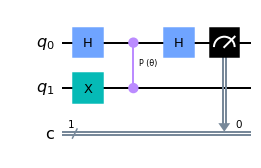

In [6]:
theta = Parameter(name='θ')

qc = QuantumCircuit(2, 1)
qc.h(0)
qc.x(1)
qc.cp(theta, 0, 1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

Transpile parameterized circuit

In [7]:
start = time.time()

theta = Parameter(name='θ')

qc = QuantumCircuit(2, 1)
qc.h(0)
qc.x(1)
qc.cp(theta, 0, 1)
qc.h(0)
qc.measure(0, 0)

qc_trans = transpile(qc, backend, optimization_level=3)

#Assign numerical values to the parameter
qc_trans_all2 = []
for ang in angles:
    qc_trans_all2.append(qc_trans.bind_parameters({theta:ang}))
    
finish = time.time()
del_time2 = finish - start

In [8]:
print('transpile time : {}s'.format(np.round(del_time2, 3)))

transpile time : 0.072s


**Things to note**
- Benefit of parametrized circuits grows with the number of circuits, circuit complexity, and the size of the backend as the time it takes for transpilation grows polynomially with the circuit size
- As numerical parameter values are needed for many optimization steps, transpiling parameterized circuits may not yeild optimal results.

without parametrizing circuit


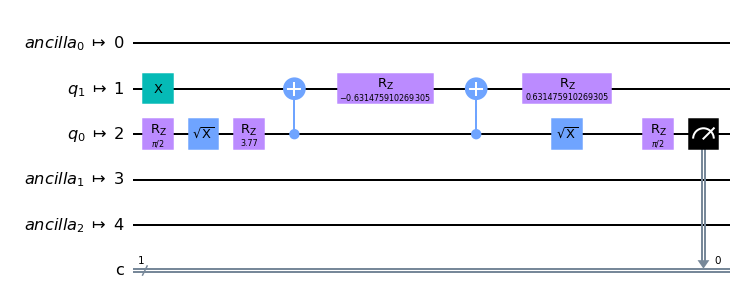

In [9]:
k = 10
print('without parametrizing circuit')
qc_trans_all[k].draw('mpl')

using parametrized circuit


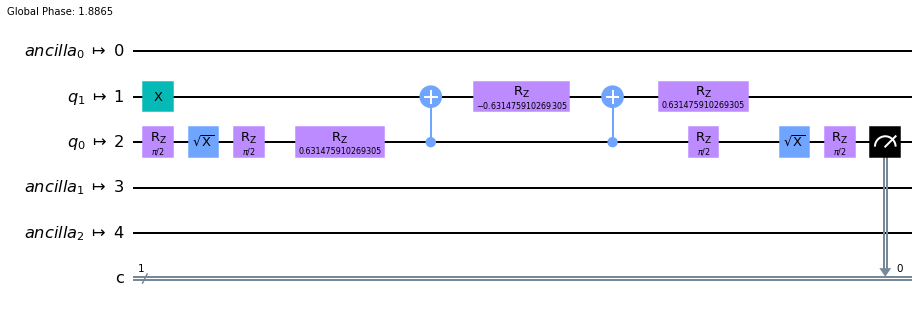

In [10]:
print('using parametrized circuit')
qc_trans_all2[k].draw('mpl')

### Build parametrized circuit

[u gate](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Single-Qubit-Gates)

#### parameter

In [11]:
theta, gamma, lam = Parameter('θ'), Parameter('γ'), Parameter('λ') 
myqc1 = QuantumCircuit(1)
myqc1.u(theta, gamma, lam, 0)
print(myqc1)

myvals = [1, 2, 3]
mybc1 = myqc1.bind_parameters({theta:1, gamma:2, lam:3})
#mybc1 = myqc1.assign_parameters(myvals)
print(mybc1)

   ┌──────────┐
q: ┤ U(θ,γ,λ) ├
   └──────────┘
   ┌──────────┐
q: ┤ U(1,2,3) ├
   └──────────┘


Note: The parameter values are assigned in the alphabetical order rather than the insertion order when `assign_parameters` method is used.

#### parameter vector

In [12]:
ang = ParameterVector('φ', 3)
myqc2 = QuantumCircuit(1) 
myqc2.u(*ang, 0)
print(myqc2)

mybc2 = myqc2.assign_parameters(myvals)
#mybc2 = myqc2.bind_parameters({ang:myvals})
print(mybc2)

   ┌───────────────────┐
q: ┤ U(φ[0],φ[1],φ[2]) ├
   └───────────────────┘
   ┌──────────┐
q: ┤ U(1,2,3) ├
   └──────────┘


#### partial binding

In [13]:
theta, gamma, lam = Parameter('θ'), Parameter('γ'), Parameter('λ') 
myqc1 = QuantumCircuit(1)
myqc1.u(theta, gamma, lam, 0)
print(myqc1)

myvals = [1, 2, 3]
mybc1 = myqc1.bind_parameters({theta:1, gamma:2})
print(mybc1)

   ┌──────────┐
q: ┤ U(θ,γ,λ) ├
   └──────────┘
   ┌──────────┐
q: ┤ U(1,2,λ) ├
   └──────────┘


In [14]:
two_angs, one_ang = ParameterVector('δ', 2), Parameter('ε')
myqc3 = QuantumCircuit(1)
myqc3.u(*two_angs, one_ang, 0)
print(myqc3)

mybc3 = myqc3.bind_parameters({two_angs:[1, 2]})
print(mybc3)

   ┌────────────────┐
q: ┤ U(δ[0],δ[1],ε) ├
   └────────────────┘
   ┌──────────┐
q: ┤ U(1,2,ε) ├
   └──────────┘


<div class="alert alert-success">
    <h3>Hands-on exercise 1.</h3>
    <p>
    Build a five qubit quantum circuit where a `rx` gate with an unique parametrized angle is applied to each qubit. Then apply `cp` gates with different parametrized angles between the $k$th and $k$th+1 qubits.
Assign numerical values that you want only to `cp` gates.
    </p>
</div>

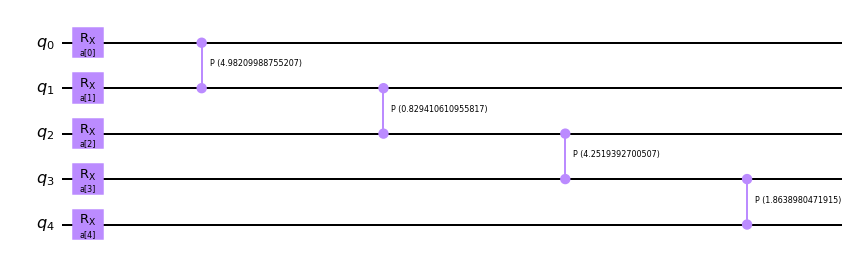

In [15]:
## your code goes here

n = 5

a = ParameterVector('a', n)
b = ParameterVector('b', n-1)

qc_rx = QuantumCircuit(n)
for k in range(n):
    qc_rx.rx(a[k], k)

qc_cp = QuantumCircuit(n)
for k in range(n-1):
    qc_cp.cp(b[k], k, k+1)
    
myqc = qc_rx.compose(qc_cp)

ang_all = 2 * np.pi * np.random.rand(n-1)
mybc = myqc.bind_parameters({b:ang_all})
mybc.draw('mpl')

## Usecase 1. Data Encoding - Quantum feature map for QSVM 

QSVM : Quantum Support Vector Machine
- Reference : [_Havlicek et al_.  Nature **567**, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2)

<div><img src="images/QSVM_1d.png" width="400"/></div>

### 1-dim data

[1.80770902 3.75492036 2.34022183 1.86887147 2.55570434]


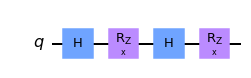

In [16]:
num = 500
data = 2 * np.pi * np.random.rand(num)
print(data[:5])

x = Parameter(name='x')
qc_data = QuantumCircuit(1)
qc_data.h(0)
qc_data.rz(x, 0)
qc_data.h(0)
qc_data.rz(x, 0)

qc_data.draw('mpl')

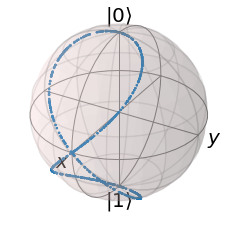

In [17]:
Xop, Yop, Zop = X.to_matrix(), Y.to_matrix(), Z.to_matrix()

def state_to_bloch(state_vec):
    phi = st.data
    bx = phi.conjugate() @ Xop @ phi
    by = phi.conjugate() @ Yop @ phi
    bz = phi.conjugate() @ Zop @ phi
    return [bx, by, bz]


st_data = [Statevector.from_instruction(qc_data.assign_parameters([dat]))for dat in data]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
b = Bloch(axes=ax)
b.point_color = ['tab:blue']
b.point_marker = ['o']
b.point_size =[2]

for st in st_data:
    v = state_to_bloch(st)
    b.add_points(v)
    
b.show()


### N-dim data 
- Check out **Data encoding circuits** in [Qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html)

**[ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)**

$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d,$$ 

where $$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}.$$
    
`ZZFeatureMap` is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None,
             parameter_prefix='x', insert_barriers=False)
```

In [18]:
data = 2 * np.pi * np.random.rand(5, 3)

df = pd.DataFrame(data)
df.rename(columns=dict(zip(df.columns, ['feat1', 'feat2', 'feat3'])))

,feat1,feat2,feat3
0,0.881035,1.934132,1.968311
1,2.585428,4.760217,4.896926
2,2.622616,3.616151,3.946556
3,3.205027,0.563507,2.827244
4,4.247817,4.194069,0.468430


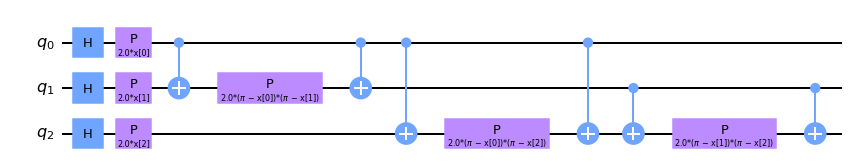

In [19]:
feat_map = ZZFeatureMap(3, reps=1)
feat_map.decompose().draw('mpl')

the number of quantum circuits : 5


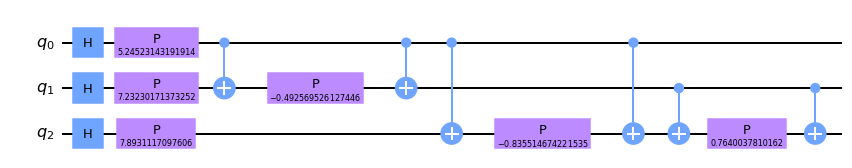

In [20]:
feat_map_data = [feat_map.assign_parameters(dat) for dat in data]
print('the number of quantum circuits : {}'.format(len(feat_map_data)))
feat_map_data[2].decompose().draw('mpl')

<div class="alert alert-success">
    <h3>Hands-on exercise 2.</h3>
    <p>
    Encode the following data, `data_ex`, using the `ZZFeatureMap` with 2 repetition.</p>
</div>

In [21]:
data_ex = 7*np.random.rand(10, 5)

df_ex = pd.DataFrame(data_ex)
df_ex.rename(columns=dict(zip(df_ex.columns,['feat1', 'feat2', 'feat3', 'feat4', 'feat5'])))

,feat1,feat2,feat3,feat4,feat5
0,3.704409,1.459107,6.739444,4.323264,0.086875
1,4.241889,0.249897,2.312293,6.213391,1.473847
2,6.876573,3.490116,4.389322,2.049181,2.007776
3,6.122943,5.922220,5.803088,3.855043,0.672778
4,6.881514,1.513573,1.769233,4.358420,5.626670
5,6.151869,6.406123,0.927164,0.141903,0.015043
6,4.336908,4.309183,4.286459,2.714046,5.321975
7,6.416338,5.221135,6.280145,1.136737,1.975622
8,5.557404,2.722492,0.062022,0.001664,4.878389
9,2.420501,1.576014,5.970689,1.451910,2.274011


Number of circuits : 10


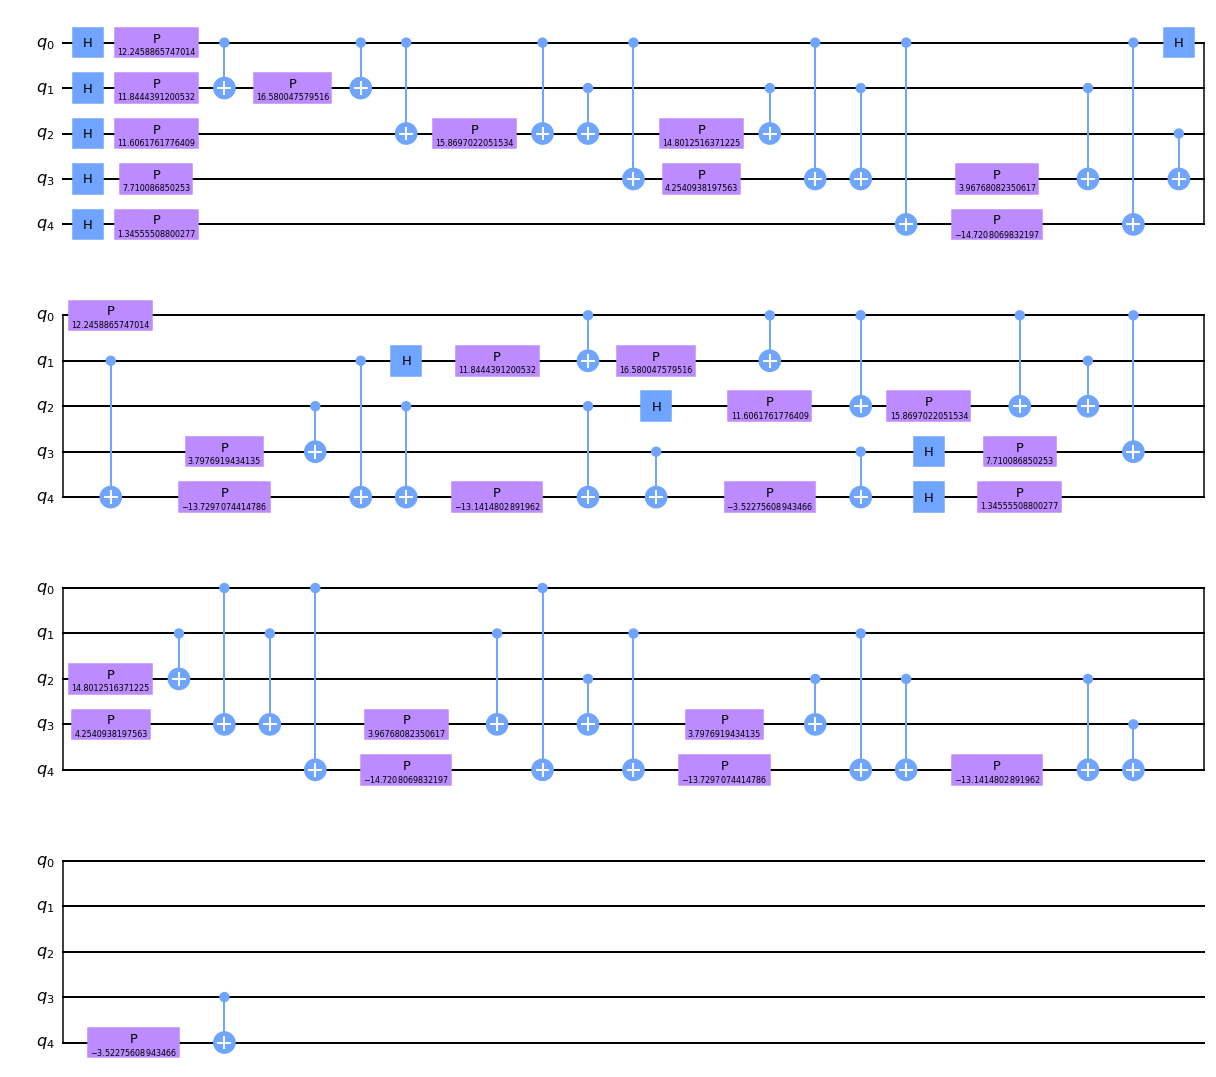

In [22]:
## your code goes here

num_q = data_ex.shape[1]
my_map = ZZFeatureMap(num_q, reps=2)

circ_map = [my_map.assign_parameters(data) for data in data_ex]
print("Number of circuits : {}".format(len(circ_map)))
circ_map[3].decompose().draw('mpl')

## Usecase 2. Ansatz preparation- VQA

VQA : Variational Quantum Algorithm

- Check out the section **N-local circuits** in [Qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html)

**[EfficientSU2](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html#qiskit.circuit.library.EfficientSU2)**

`EfficientSU2` is a parametrized quantum circuit generating a hardware efficient, heuristic ansatz with alternating rotation and entanglement layer, which is used for variational quantum algorithms or classification circuit for machine learning.

```python
EfficientSU2(num_qubits=None, su2_gates=None, entanglement='reverse_linear', 
             reps=3, skip_unentangled_qubits=False, 
             skip_final_rotation_layer=False, parameter_prefix='θ',
             insert_barriers=False, initial_state=None)
```

Check [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html#qiskit.circuit.library.TwoLocal) for entanglement strategies.

<div class="alert alert-success">
    <h3>Hands-on exercise 3.</h3>
    <p>
    Build a circuit to generate a hardware efficient ansatz for a 5 qubit system through `EfficientSU2` with 3 repetitions, using `h` and `rz` gates for `su2_gates`, implementing the `entangler_map` $= [[2, 1], ~ [1, 0], ~ [2, 3], ~[3, 4]]$.</p>
</div>

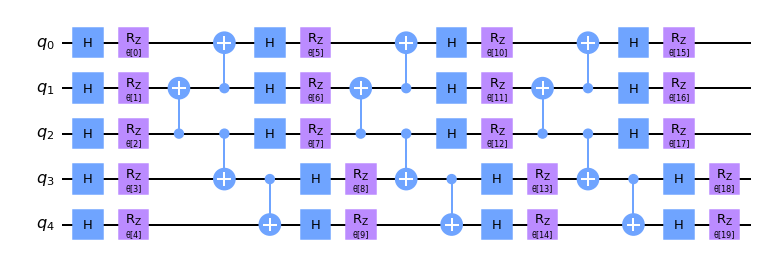

In [23]:
entangler_map = [[2, 1], [1, 0], [2, 3], [3, 4]]
qc = EfficientSU2(5, ['h', 'rz'], entanglement=entangler_map)
qc.decompose().draw('mpl')

**Further Reading** 
- [Parametrized quantum circuits](https://learn.qiskit.org/course/machine-learning/parameterized-quantum-circuits#parameterized-1-0)
- [Advanced Circuit](https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html)
- [PauliFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html#qiskit.circuit.library.PauliFeatureMap)

In [24]:
import qiskit.tools.jupyter
%qiskit_version_table